# This is going to be the final notebook to present all findings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import src.visualization as vs
import src.process as process
import models.lib as modlib

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

# models

from sklearn.ensemble import RandomForestClassifier

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

RSEED = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')

In [3]:
vs.nice_summary(data)

,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,country,object,22,168979,-,-,0,-,-,-,-,-,-,-
1,staff_pick,bool,2,168979,-,-,147323,-,-,-,-,-,-,-
2,state,int64,2,168979,-,-,74200,0.56,0.5,0.0,0.0,1.0,1.0,1.0
3,usd_pledged,float64,69803,168979,-,-,14821,12110.97,83739.32,0.0,100.0,1457.0,6235.0,8596474.58
4,usd_type,object,2,168959,20,0.01,0,-,-,-,-,-,-,-
5,converted_goal,float64,45238,168979,-,-,0,41096.88,1110956.93,0.01,1500.0,5000.0,13297.7,152350076.0
6,pledge_per_backer,float64,25712,168979,-,-,14821,71.83,136.32,0.0,20.25,46.0,83.73,10000.0
7,len_blurb,float64,35,168977,2,-,0,19.01,4.98,1.0,16.0,20.0,22.0,35.0
8,len_name,int64,20,168979,-,-,0,5.71,2.71,1.0,4.0,6.0,8.0,27.0
9,category_name,object,159,168979,-,-,0,-,-,-,-,-,-,-


In [4]:
data['day_hour_launch'] = data['day_hour_launch'].astype(str)
data['day_hour_deadline'] = data['day_hour_deadline'].astype(str)

data = data.drop(['staff_pick','usd_pledged','pledge_per_backer'], axis=1)
# data = data.drop(['month_launch','weekday_launch','day_hour_launch'], axis=1)
# data = data.drop(['month_deadline','weekday_deadline','day_hour_deadline'], axis=1)
# data = data.drop(['category_name', 'parent_category'], axis=1)
data.sample(5, random_state=RSEED)

,country,state,usd_type,converted_goal,len_blurb,len_name,category_name,parent_category,launch_to_deadline,creation_to_launch,month_launch,weekday_launch,day_hour_launch,month_deadline,weekday_deadline,day_hour_deadline
10790,US,1,international,2000.00,8.0,8,Rock,music,2694818,1742779,November,Friday,1,December,Monday,5
26459,CA,1,domestic,4743.59,13.0,7,Nonfiction,publishing,2592000,349404,November,Wednesday,14,December,Friday,14
168147,US,1,domestic,4000.00,18.0,7,Dance,dance,3024000,16619516,April,Friday,4,May,Friday,4
32580,US,0,international,35000.00,17.0,2,Periodicals,publishing,2592000,6379447,July,Tuesday,18,August,Thursday,18
156442,US,0,domestic,4000.00,26.0,4,Public Art,art,5130896,1349404,January,Monday,17,March,Friday,3


## Preprocessing
- Performing train-test-split
- defining target variable = 'state' -> binary success/failure
- splitting categories up in numerical and categorical features for separate preprocessing
- load models from /models/lib.py
- Applying StandardScaler() to numerical features and imputing them with median() where necessary using SimpleImpute() -> not necessary in this dataset
- Applying OneHotEncoding() to categorical features and dropping the first. Imputing with "missing" where necessary using SimpleImpute() -> not necessary in this dataset

In [5]:
y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)

target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = modlib.models()

preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')
xgb_scaled = process.model_process_pipeline({'XGB':  XGBClassifier(seed=RSEED)}, preprocessor, prefix='scaled')

Categorical Features: ['country', 'usd_type', 'category_name', 'parent_category', 'month_launch', 'weekday_launch', 'day_hour_launch', 'month_deadline', 'weekday_deadline', 'day_hour_deadline'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']


## Cross Validation
- to get a rough idea which models might perform best

In [6]:
predicted_y_dict = process.model_cv_scores(X_train, y_train, scaled_models, kfolds=10, RSEED=RSEED, shuffle=True, n_jobs=1)
display(vs.nice_scores(y_train, predicted_y_dict))

scaledDT - Time taken: 205.01 seconds
scaledXGB - Time taken: 33.57 seconds
scaledABC - Time taken: 55.42 seconds
scaledLR - Time taken: 9.94 seconds


,FBeta,Accuracy,Recall,Precision
scaledDT,0.745,0.713,0.742,0.745
scaledXGB,0.817,0.793,0.809,0.819
scaledABC,0.792,0.759,0.760,0.800
scaledLR,0.805,0.771,0.764,0.816


## Predicting y_test using the above models

In [7]:
predictes_y_test_dict, fitted_models_dict = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

scaledDT - Time taken: 23.88 seconds
scaledXGB - Time taken: 3.74 seconds
scaledABC - Time taken: 6.30 seconds
scaledLR - Time taken: 1.18 seconds


,FBeta,Accuracy,Recall,Precision
scaledDT,0.741,0.709,0.739,0.741
scaledXGB,0.817,0.795,0.817,0.817
scaledABC,0.792,0.759,0.762,0.800
scaledLR,0.806,0.772,0.766,0.817


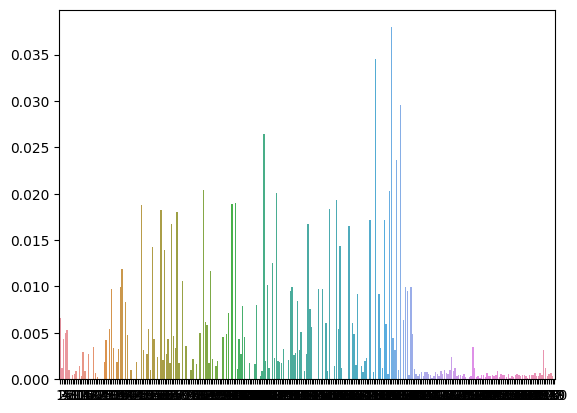

In [8]:
importances = fitted_models_dict['scaledXGB'].steps[1][1].feature_importances_

# create the barplot using Seaborn
sns.barplot(x=np.arange(len(importances)), y=importances)

# set the x-axis tick labels
plt.xticks(np.arange(len(importances)), labels=np.arange(1, len(importances)+1));

## Running GridSearch() on the most promising models
 - RandomForestClassifier()
 - XGBoost()

In [9]:
nice_models = {mod: scaled_models[mod] for mod in ['scaledXGB']}
scorer = make_scorer(fbeta_score,beta=0.5)

best_models = process.model_selection_search(X_train, y_train, nice_models,
                                              modlib.random_grids(), search_method=RandomizedSearchCV,
                                              cv=5, scoring=scorer, n_iter = 100, random_state=RSEED, verbose=2, n_jobs=1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END XGB__colsample_bytree=0.5, XGB__gamma=0.4, XGB__learning_rate=0.1, XGB__max_depth=3, XGB__reg_alpha=10, XGB__reg_lambda=1; total time=   1.4s
[CV] END XGB__colsample_bytree=0.5, XGB__gamma=0.4, XGB__learning_rate=0.1, XGB__max_depth=3, XGB__reg_alpha=10, XGB__reg_lambda=1; total time=   1.4s
[CV] END XGB__colsample_bytree=0.5, XGB__gamma=0.4, XGB__learning_rate=0.1, XGB__max_depth=3, XGB__reg_alpha=10, XGB__reg_lambda=1; total time=   1.4s
[CV] END XGB__colsample_bytree=0.5, XGB__gamma=0.4, XGB__learning_rate=0.1, XGB__max_depth=3, XGB__reg_alpha=10, XGB__reg_lambda=1; total time=   1.4s
[CV] END XGB__colsample_bytree=0.5, XGB__gamma=0.4, XGB__learning_rate=0.1, XGB__max_depth=3, XGB__reg_alpha=10, XGB__reg_lambda=1; total time=   1.4s
[CV] END XGB__colsample_bytree=0.3, XGB__gamma=0.0, XGB__learning_rate=0.1, XGB__max_depth=18, XGB__reg_alpha=100, XGB__reg_lambda=0.1; total time=   4.3s
[CV] END XGB__colsample_byt

In [10]:
for model_name, model in best_models.items():
    print(f"GridSearch results for {model_name}:\n------")
    print('Best score:{:.2f}'.format(model.best_score_))
    print("Best parameters:{}".format(model.best_params_))
    best_predictions = model.best_estimator_.predict(X_test)
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
    print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("------\n")

GridSearch results for bestscaledXGB:
------
Best score:0.82
Best parameters:{'XGB__reg_lambda': 10, 'XGB__reg_alpha': 1e-05, 'XGB__max_depth': 18, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0.2, 'XGB__colsample_bytree': 0.4}
Final accuracy score on the testing data: 0.7945
Final F-score on the testing data: 0.8177
Final recall score on the testing data: 0.8140
Final precision on the testing data: 0.8186
------



In [11]:
nice_models = {mod: scaled_models[mod] for mod in ['scaledXGB']}

best_models = process.model_selection_search(X_train, y_train, nice_models,
                                              modlib.random_grids(), search_method=RandomizedSearchCV,
                                              cv=5, scoring='accuracy', n_iter = 100, random_state=RSEED, verbose=1, n_jobs=1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
scaledXGB - Time taken: 2110.41 seconds


In [13]:
for model_name, model in best_models.items():
    print(f"GridSearch results for {model_name}:\n------")
    print('Best score:{:.2f}'.format(model.best_score_))
    print("Best parameters:{}".format(model.best_params_))
    best_predictions = model.best_estimator_.predict(X_test)
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
    print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("------\n")

GridSearch results for bestscaledXGB:
------
Best score:0.79
Best parameters:{'XGB__reg_lambda': 10, 'XGB__reg_alpha': 1e-05, 'XGB__max_depth': 18, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0.2, 'XGB__colsample_bytree': 0.4}
Final accuracy score on the testing data: 0.7945
Final F-score on the testing data: 0.8177
Final recall score on the testing data: 0.8140
Final precision on the testing data: 0.8186
------



In [ ]:
fbeta = round(fbeta_score(data.state, data.staff_pick, beta=0.5), 3)
accuracy = round(accuracy_score(data.state, data.staff_pick), 3)
recall = round(recall_score(data.state, data.staff_pick), 3)
precision = round(precision_score(data.state, data.staff_pick), 3)

scores = pd.DataFrame()    
scores['base model'] = [fbeta, accuracy, recall, precision]

# few false positives: staff_picked it, but it wasn't successful
# many false negatives: staff didn't pick it, but they were successful

display(scores)

# 13.5% are staff picked
display(data.query('staff_pick == True').state.value_counts())

display(data.shape)